In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.misc import derivative
import plotly.graph_objects as go
import plotly.io as pio
import requests
from lmfit import minimize, Parameters, Parameter, report_fit
pio.renderers.default = "notebook"
%matplotlib inline
#%matplotlib qt
plt.style.use('ggplot')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [2]:
# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [13]:
covid = pd.read_excel('covid_yandex_data.xlsx')
add_inf = pd.read_csv('owid-covid-data.csv')
covid.rename(columns={'Страна':'country', 'Дата':'date', 'Общее число случаев':'total_cases', 'Общее число выздоровевших':'total_recovered', 'Общее число смертей':'total_deaths', 'Число подтвержденных заражений за сутки':'new_cases', 'Выздоровлений за день':'new_recovered', 'Смертей за день':'new_deaths'}, inplace=True)
covid.head()

,country,date,total_cases,total_recovered,total_deaths,new_cases,new_recovered,new_deaths
0,Marshall Islands,2020-01-22,0,0,0,0,0,0
1,Marshall Islands,2020-01-23,0,0,0,0,0,0
2,Marshall Islands,2020-01-24,0,0,0,0,0,0
3,Marshall Islands,2020-01-25,0,0,0,0,0,0
4,Marshall Islands,2020-01-26,0,0,0,0,0,0


In [14]:
selected_country = covid[(covid.country == 'Беларусь') & (covid.total_cases > 0)]
for col in ['total_cases', 'total_recovered', 'total_deaths', 'new_cases', 'new_recovered', 'new_deaths']:
    selected_country[col] = selected_country[col].astype('float')
    N = (add_inf[add_inf.location == 'Belarus']['population'].iloc[0])
    #нормировка на 100 000
    selected_country[col] = selected_country[col].mul(100000/N)
selected_country

<ipython-input-14-b030434ea5f1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-b030434ea5f1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,date,total_cases,total_recovered,total_deaths,new_cases,new_recovered,new_deaths
5077,Беларусь,2020-02-28,0.010583,0.000000,0.000000,0.010583,0.000000,0.000000
5078,Беларусь,2020-02-29,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000
5079,Беларусь,2020-03-01,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000
5080,Беларусь,2020-03-02,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000
5081,Беларусь,2020-03-03,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
5350,Беларусь,2020-11-27,1393.041892,1165.713388,12.022028,17.154672,14.635972,0.084662
5351,Беларусь,2020-11-28,1410.937357,1179.502739,12.096107,17.895466,13.789351,0.074079
5352,Беларусь,2020-11-29,1428.758744,1199.821659,12.180769,17.821386,20.318920,0.084662
5353,Беларусь,2020-11-30,1446.103905,1210.044616,12.254849,17.345162,10.222957,0.074079


In [15]:
def smoother_plus_infected(frame):
    frame['total_cases_smoothed']=frame.total_cases.rolling(7, min_periods=1, center=True).mean()
    frame['total_deaths_smoothed']=frame.total_deaths.rolling(7, min_periods=1, center=True).mean()
    frame['total_recovered_smoothed']=frame.total_recovered.rolling(7, min_periods=1, center=True).mean()
    frame['new_cases_smoothed'] = frame.new_cases.rolling(7, min_periods=1, center=True).mean()
    frame['new_recovered_smoothed'] = frame.new_recovered.rolling(7, min_periods=1, center=True).mean()
    frame['new_deaths_smoothed'] = frame.new_deaths.rolling(7, min_periods=1, center=True).mean()
    frame['infected'] = frame['total_cases_smoothed'] - frame['total_deaths_smoothed'] - frame['total_recovered_smoothed']

In [16]:
smoother_plus_infected(selected_country)

<ipython-input-15-9dae4821d275>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-9dae4821d275>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-9dae4821d275>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-9dae482

In [17]:
selected_country

,country,date,total_cases,total_recovered,total_deaths,new_cases,new_recovered,new_deaths,total_cases_smoothed,total_deaths_smoothed,total_recovered_smoothed,new_cases_smoothed,new_recovered_smoothed,new_deaths_smoothed,infected
5077,Беларусь,2020-02-28,0.010583,0.000000,0.000000,0.010583,0.000000,0.000000,0.010583,0.000000,0.000000,0.002646,0.000000,0.000000,0.010583
5078,Беларусь,2020-02-29,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000,0.010583,0.000000,0.000000,0.002117,0.000000,0.000000,0.010583
5079,Беларусь,2020-03-01,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000,0.019402,0.000000,0.000000,0.010583,0.000000,0.000000,0.019402
5080,Беларусь,2020-03-02,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000,0.025701,0.000000,0.000000,0.009071,0.000000,0.000000,0.025701
5081,Беларусь,2020-03-03,0.010583,0.000000,0.000000,0.000000,0.000000,0.000000,0.033260,0.000000,0.000000,0.007559,0.000000,0.000000,0.033260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350,Беларусь,2020-11-27,1393.041892,1165.713388,12.022028,17.154672,14.635972,0.084662,1393.941427,12.014469,1166.189613,16.879520,14.578523,0.081639,215.737345
5351,Беларусь,2020-11-28,1410.937357,1179.502739,12.096107,17.895466,13.789351,0.074079,1410.973641,12.096107,1180.932925,17.032214,14.743312,0.081639,217.944609
5352,Беларусь,2020-11-29,1428.758744,1199.821659,12.180769,17.821386,20.318920,0.084662,1419.578190,12.138438,1188.231761,17.232279,14.348474,0.082898,219.207990
5353,Беларусь,2020-11-30,1446.103905,1210.044616,12.254849,17.345162,10.222957,0.074079,1428.316384,12.178653,1195.662630,17.370560,14.430666,0.080429,220.475101


# SIR model

In [19]:
df = selected_country.reset_index()
def ode_model_SIR(z, t, betta, gamma):
    S, I, R = z
    N = S + I + R
    dSdt = -betta*S*I/N
    dIdt = betta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

def ode_solver_SIR(t, initial_conditions, params):
    initI, initR, initN = initial_conditions
    betta, gamma = params['betta'].value, params['gamma'].value
    initS = initN - (initI + initR)
    res = odeint(ode_model_SIR, [initS, initI, initR], t, args=(betta, gamma))
    return res

In [20]:
def findI(t0, T, S0, betta, gamma):
    
    initN = 100000
    initR = initN - S0
    initI = df.loc[t0]['infected']


    params = Parameters()
    params.add('betta', value=betta, min=0, max=41)
    params.add('gamma', value=gamma, min=0, max=41)

    #days = selected_country.shape[0]
    initial_conditions = [initI, initR, initN]
    params['betta'].value, params['gamma'].value = [betta, gamma]
    tspan = np.arange(t0, T, 1)
    sol = ode_solver_SIR(tspan, initial_conditions, params)
    S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]
    
    return I

In [21]:
def f(t0, T, S0, betta, gamma): 
    I_estimated = findI(t0, T, S0, betta, gamma)
    I_real = df['infected'].tolist()
    W = 0
    for i in range(t0, T):
        n = i - t0
        W += (I_estimated[n] -  I_real[i])**2
        
    return W

In [22]:
def dFdBetta(t0, T, S0, betta, gamma):
    dBetta = 0.1
    betta1 = betta + dBetta
    return (f(t0, T, S0, betta1, gamma) - f(t0, T, S0, betta, gamma)) / dBetta

In [23]:
def dFdS0(t0, T, S0, betta, gamma):
    dS0 = 0.1
    S01 = S0 + dS0
    return (f(t0, T, S01, betta, gamma) - f(t0, T, S0, betta, gamma)) / dS0

#  


In [24]:
def calculate_gamma(data):
    gamma = 0
    for i in range(data.shape[0] - 1):
        gamma += 1/data.shape[0]*(data['total_recovered'].iloc[i+1]-data['total_recovered'].iloc[i])/data['infected'].iloc[i]
    return gamma
calculate_gamma(df)

0.06799147437307225

In [25]:
def findBetta(S0, gamma):  
    beta_left  = 0
    beta_right = 40
    while beta_right - beta_left > 0.00001:
        # середина отрезка
        beta_middle = (beta_right + beta_left) / 2
        # сравниваем ошибки на середине beta и чуть правее
        if dFdBetta(t0, T, S0, beta_middle, gamma) > 0:
            beta_right = beta_middle
            beta_opt = beta_left 
        if dFdBetta(t0, T, S0, beta_middle, gamma) < 0:
            beta_left = beta_middle
            beta_opt = beta_right
    return beta_opt

1462.3758926391602
12.590770721435547
0.07142857142857142


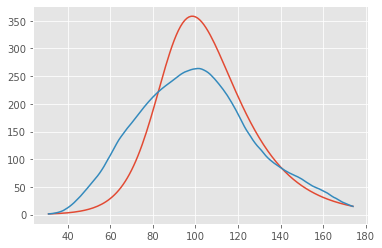

In [30]:
t0 = 0
while (int(df.loc[t0]['infected']) == 0):
    t0 += 1
T = 175
T_max = df.shape[0] - 1
N_norm = 100000

gamma = 1/14


#задачем правый и левый концы s
s_left = int(df.reset_index().loc[T_max]["total_cases"])
s_right = 100000

s_opt = 0
beta_opt = 0


s_h = 1 

while s_right-s_left > 1: # условие остановки
    # середина отрезка
    s_middle = (s_right + s_left) / 2
    #beta_middle = (beta_right + beta_left) / 2
    #gamma_middle = (gamma_right + gamma_left) / 2
    # вычисляем значение ошибки для середины s
    # находим оптимальную бету для середины s
    beta_opt_middle = findBetta(s_middle, gamma)

    # вычисляем значение ошибки для сдвинутого от центра s
    # находим оптимальную бету для сдвинутого s
    beta_opt_shift = findBetta(s_middle + s_h, gamma)
    
    err_middle_s = f(t0, T, s_middle, beta_opt_middle, gamma)
    err_shift_s = f(t0, T, s_middle + s_h, beta_opt_shift, gamma)
    
    # сравниваем ошибки на разных s
    if err_middle_s < err_shift_s: #ошибка возрастает, сдвигаем правый конец влево
        s_right = s_middle
        beta_opt = beta_opt_middle
        
    if err_middle_s > err_shift_s: #ошибка убывает, сдвигаем левый конец вправо      
        s_left = s_middle
        beta_opt = beta_opt_shift
        
s_opt = (s_right + s_left) / 2


print(s_opt)
print(beta_opt)
print(gamma)


plt.plot(range(t0,T), findI(t0,T, s_opt , beta_opt, gamma))
plt.plot(range(t0,T), df['infected'].to_list()[t0:T])

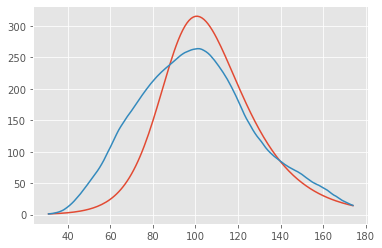

In [31]:
S0 = s_opt
betta = beta_opt
gamma_best = 0
e = 10**10

for g in range(1, 10000, 1):
    gamma = g / 10000
    f_now = f(t0, T, S0, betta, gamma)
    if f_now < e:
        e = f_now
        gamma_best = gamma
        
plt.plot(range(t0,T), findI(t0,T, s_opt , beta_opt, gamma_best))
plt.plot(range(t0,T), df['infected'].to_list()[t0:T])

In [138]:
gamma_best

0.1116